In [67]:
import os
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [68]:
random_seed = 42
torch.random.manual_seed(random_seed)
np.random.seed(random_seed)

# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('LunarLander-v2', render_mode='rgb_array')
observation_space = env.observation_space.shape[0]  # 状态空间
action_space = env.action_space.n   # 动作空间

## PPO

In [69]:
class Memory:
    def __init__(self):
        # 初始化存储动作、状态、对数概率、奖励和终止标志的列表
        self.actions = []       # 存储动作
        self.states = []        # 存储状态
        self.logprobs = []      # 存储对数概率
        self.rewards = []       # 存储奖励
        self.is_terminals = []  # 存储终止标志

    def clear_memory(self):
        # 清空所有列表中的元素
        del self.actions[:]        # 清空动作列表
        del self.states[:]         # 清空状态列表
        del self.logprobs[:]       # 清空对数概率列表
        del self.rewards[:]        # 清空奖励列表
        del self.is_terminals[:]   # 清空终止标志列表


In [70]:
class ActorCriticDiscrete(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ActorCriticDiscrete, self).__init__()

        # 定义actor网络的架构
        self.action_layer = nn.Sequential(
                nn.Linear(input_size, hidden_size),  # 输入层
                nn.ReLU(),                            # 激活函数
                nn.Linear(hidden_size, output_size), # 输出层
                nn.Softmax(dim=-1)                   # 对输出进行softmax激活
                )

        # 定义critic网络的架构
        self.value_layer = nn.Sequential(
               nn.Linear(input_size, hidden_size),  # 输入层
               nn.ReLU(),                            # 激活函数
               nn.Linear(hidden_size, 1)            # 输出层
               )

    def act(self, state, memory):
        # 将状态转换为PyTorch张量
        state = torch.from_numpy(state).float()
        # 使用actor网络计算动作概率
        action_probs = self.action_layer(state)
        # 从概率分布中采样一个动作
        dist = Categorical(action_probs)
        action = dist.sample()

        # 将状态、动作和对数概率存储在内存中
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))

        return action.item()

    def evaluate(self, state, action):
        # 使用actor网络计算动作概率
        action_probs = self.action_layer(state)
        # 创建一个Categorical分布
        dist = Categorical(action_probs)

        # 计算所选动作的对数概率
        action_logprobs = dist.log_prob(action)
        # 计算动作分布的熵
        dist_entropy = dist.entropy()

        # 使用critic网络计算状态值
        state_value = self.value_layer(state)

        return action_logprobs, torch.squeeze(state_value), dist_entropy


In [71]:
class PPOAgent:
    def __init__(self, input_size, output_size, hidden_size, lr, eps, gamma, K_epochs, eps_clip, update_timestep):
        # 使用超参数和内存初始化PPOAgent
        self.lr = lr
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.timestep = 0
        self.memory = Memory()
        self.update_timestep = update_timestep

        # 初始化actor-critic网络和优化器
        self.policy = ActorCriticDiscrete(input_size, output_size, hidden_size)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, eps=eps)
        self.policy_old = ActorCriticDiscrete(input_size, output_size, hidden_size)
        self.policy_old.load_state_dict(self.policy.state_dict())

        # 定义均方误差损失函数
        self.MseLoss = nn.MSELoss()

    def update(self):   
        # 使用蒙特卡洛方法估算状态回报
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.memory.rewards), reversed(self.memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # 对回报进行标准化
        rewards = torch.tensor(rewards, dtype=torch.float32)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)

        # 将列表转换为张量
        old_states = torch.stack(self.memory.states).detach()
        old_actions = torch.stack(self.memory.actions).detach()
        old_logprobs = torch.stack(self.memory.logprobs).detach()

        # 优化策略K次
        for _ in range(self.K_epochs):
            # 使用actor-critic网络评估旧动作和值
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # 计算重要性采样系数（pi_theta / pi_theta__old）
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # 计算替代损失
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy

            # 执行梯度下降
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # 将新权重复制到旧策略中
        self.policy_old.load_state_dict(self.policy.state_dict())

    def step(self, reward, done):
        self.timestep += 1 
        # 存储奖励和终止标志
        self.memory.rewards.append(reward)
        self.memory.is_terminals.append(done)

        # 更新策略
        if self.timestep % self.update_timestep == 0:
            self.update()
            # 更新后清空内存
            self.memory.clear_memory()
            self.timstamp = 0

    def act(self, state):
        # 使用旧策略选择动作
        return self.policy_old.act(state, self.memory)
    
    def save_checkpoint(self, directory, episode):
        # 保存当前模型检查点
        if not os.path.exists(directory):
            os.makedirs(directory)
        filename = os.path.join(directory, 'checkpoint_{}.pth'.format(batch))
        torch.save(self.policy.state_dict(), f=filename)
        print('保存当前模型至 \'{}\''.format(filename))
        
    def load_checkpoint(self, directory, filename):
        # 加载模型检查点以便重新训练
        self.policy.load_state_dict(torch.load(os.path.join(directory, filename)))
        print('重新开始训练 checkpoint \'{}\'.'.format(filename))
        return int(filename[11:-4])


In [72]:
hidden_size = 1024          # 神经元个数
update_timestep = 1200      # 每多少步更新策略
lr = 1e-4                   # 学习率
eps = 1e-4                  # 优化器Adam参数
gamma = 0.99                # 折扣因子
K_epochs = 4                # 每K个Epoch更新策略
eps_clip = 0.2              # clip 参数
# load_filename = 'checkpoint_1250.pth'
load_filename = None
batch = 0
save_directory = "./ppo_weight"

ppo_agent = PPOAgent(observation_space ,action_space, hidden_size, lr, eps, gamma, K_epochs, eps_clip, update_timestep)
BATCH_SIZE = 10
MAX_NUM_BATCH = 2000

ppo_reward_list = []

if load_filename is not None:
    batch = ppo_agent.load_checkpoint(save_directory, load_filename)

while batch <= MAX_NUM_BATCH:
    rewards = []
    total_rewards = []

    for _ in range(BATCH_SIZE):
        state = env.reset()[0]
        total_reward = 0
        done = False
        # while not done:
        for _ in range(10000):
            action = ppo_agent.act(state)
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            total_reward += reward 
            rewards.append(reward)
            ppo_agent.step(reward, done)   
            if done: 
                # total_rewards.append(total_reward)
                break
    batch += 1
    total_rewards.append(total_reward)
    
    if batch % 50 == 0 and save_directory is not None:
        ppo_agent.save_checkpoint(save_directory, batch)

    print('Batch: {}, average reward: {}'.format(batch, np.array(total_rewards).mean()))
    ppo_reward_list.append(np.array(total_rewards).mean())

env.close()
    

Batch: 1, average reward: -320.3311783868092
Batch: 2, average reward: -399.4898493317679
Batch: 3, average reward: -145.94090627599746
Batch: 4, average reward: -131.61342716519428
Batch: 5, average reward: -11.263232251774227
Batch: 6, average reward: -168.8277282156504
Batch: 7, average reward: -99.98392784575371
Batch: 8, average reward: -215.22340076084575
Batch: 9, average reward: -237.02657801502556
Batch: 10, average reward: -165.6593501993552
Batch: 11, average reward: -158.76163985891472
Batch: 12, average reward: -282.62503372947435
Batch: 13, average reward: -152.4905495932065
Batch: 14, average reward: -179.58627420952342
Batch: 15, average reward: -221.63913335437832
Batch: 16, average reward: -158.56910818891333
Batch: 17, average reward: -236.1529039542168
Batch: 18, average reward: -137.31081908356316
Batch: 19, average reward: -96.946264574095
Batch: 20, average reward: -108.00951966221031
Batch: 21, average reward: -386.7652465813577
Batch: 22, average reward: -67.57

Text(0, 0.5, 'Batch Average Reward')

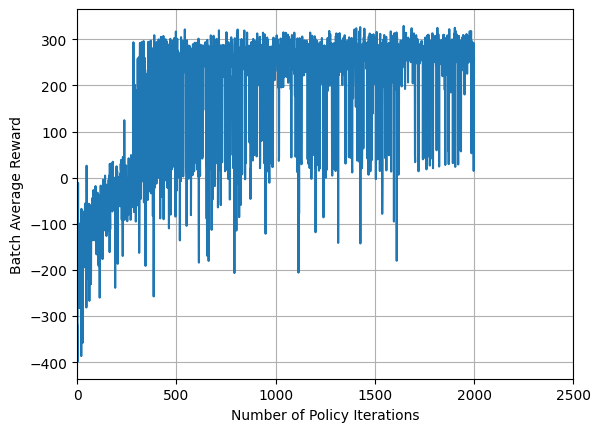

In [73]:
plt.plot(ppo_reward_list)
plt.grid(True)
plt.xlim([0,2500])
# plt.ylim([-300,300])
plt.xlabel('Number of Policy Iterations')
plt.ylabel('Batch Average Reward')

 ## PG


In [74]:
class Policy_Gradient:
    def __init__(self, hidden_size, input_size, output_size, learning_rate, eps, gamma):
        # 网络结构
        self.model = torch.nn.Sequential(
            nn.Linear(input_size, hidden_size, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size, bias=False),
            nn.Softmax(dim=-1)
        ).to(device)

        self.lr = learning_rate # 学习率
        self.eps = eps
        self.gamma = gamma  #折扣

        #优化器
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, eps=eps)
        self.reset()

    def forward(self, x):
        return self.model(x)

    def reset(self):
        self.episode_actions = torch.tensor([], requires_grad=True, device=device)
        self.episode_rewards = []

    def save_checkpoint(self, directory, episode):
        if not os.path.exists(directory):
            os.makedirs(directory)
        filename = os.path.join(directory, 'checkpoint_{}.pth'.format(episode))
        torch.save(self.model.state_dict(), f=filename)
        print('保存当前模型至 \'{}\''.format(filename))

    def load_checkpoint(self, directory, filename):
        self.model.load_state_dict(torch.load(os.path.join(directory, filename)))
        print('重新开始训练 checkpoint \'{}\'.'.format(filename))
        return int(filename[11:-4])

    def backward(self):
        future_reward = 0
        rewards = []
        for r in self.episode_rewards[::-1]:
            future_reward = r + self.gamma * future_reward  # 折扣回报
            rewards.append(future_reward)
        rewards = torch.tensor(rewards[::-1], dtype=torch.float32, device=device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)   # 归一化
        loss = torch.sum(torch.mul(self.episode_actions, rewards).mul(-1))  # 损失函数
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.reset()

In [75]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
# load_filename = 'checkpoint_6800.pth'
load_filename = None
save_directory = "./pg_weight"
batch_rewards = []
batch = 0
epsilon = 1e-4
pg_reward_list = []

pg_agent = Policy_Gradient(hidden_size=hidden_size, input_size=observation_space, output_size=action_space, learning_rate=lr, eps=eps, gamma=gamma)

if load_filename is not None:
    batch = pg_agent.load_checkpoint(save_directory, load_filename)
while batch <= MAX_NUM_BATCH:
    batch_rewards = []

    for _ in range(BATCH_SIZE):
        state = env.reset()[0]
        done = False
        # while not done:
        for _ in range(10000):
            # env.render()
            action_probs = pg_agent.forward(torch.tensor(state, dtype=torch.float32, device=device)) 
            distribution = Categorical(action_probs)    # 计算分布
            action = distribution.sample()  # 选择动作
            state, reward, done, _, _ = env.step(action.item())
            pg_agent.episode_actions = torch.cat([pg_agent.episode_actions, distribution.log_prob(action).reshape(1)])
            pg_agent.episode_rewards.append(reward)
            if done:
                break
        
        batch_rewards.append(np.sum(pg_agent.episode_rewards))
        pg_agent.backward()
        
    batch += 1
    
    if batch % 50 == 0 and save_directory is not None:
        pg_agent.save_checkpoint(save_directory, batch)

    print('Batch: {}, average reward: {}'.format(batch, np.array(batch_rewards).mean()))
    pg_reward_list.append(np.array(batch_rewards).mean())
     

env.close()

Batch: 1, average reward: -179.82847211362952
Batch: 2, average reward: -184.78810765699845
Batch: 3, average reward: -132.88758244422513
Batch: 4, average reward: -161.47970316283894
Batch: 5, average reward: -162.0648273873538
Batch: 6, average reward: -138.6181556968782
Batch: 7, average reward: -132.5848746880832
Batch: 8, average reward: -143.81022519839286
Batch: 9, average reward: -123.19238884629942
Batch: 10, average reward: -205.3812631441314
Batch: 11, average reward: -128.6343615319356
Batch: 12, average reward: -141.05798605605997
Batch: 13, average reward: -164.13574414815008
Batch: 14, average reward: -168.68671135587903
Batch: 15, average reward: -169.3863773048028
Batch: 16, average reward: -159.06225793430514
Batch: 17, average reward: -144.00238484998502
Batch: 18, average reward: -114.68028849190179
Batch: 19, average reward: -127.39757293554388
Batch: 20, average reward: -146.83833930236898
Batch: 21, average reward: -152.0766683624091
Batch: 22, average reward: -1

Text(0, 0.5, 'Batch Average Reward')

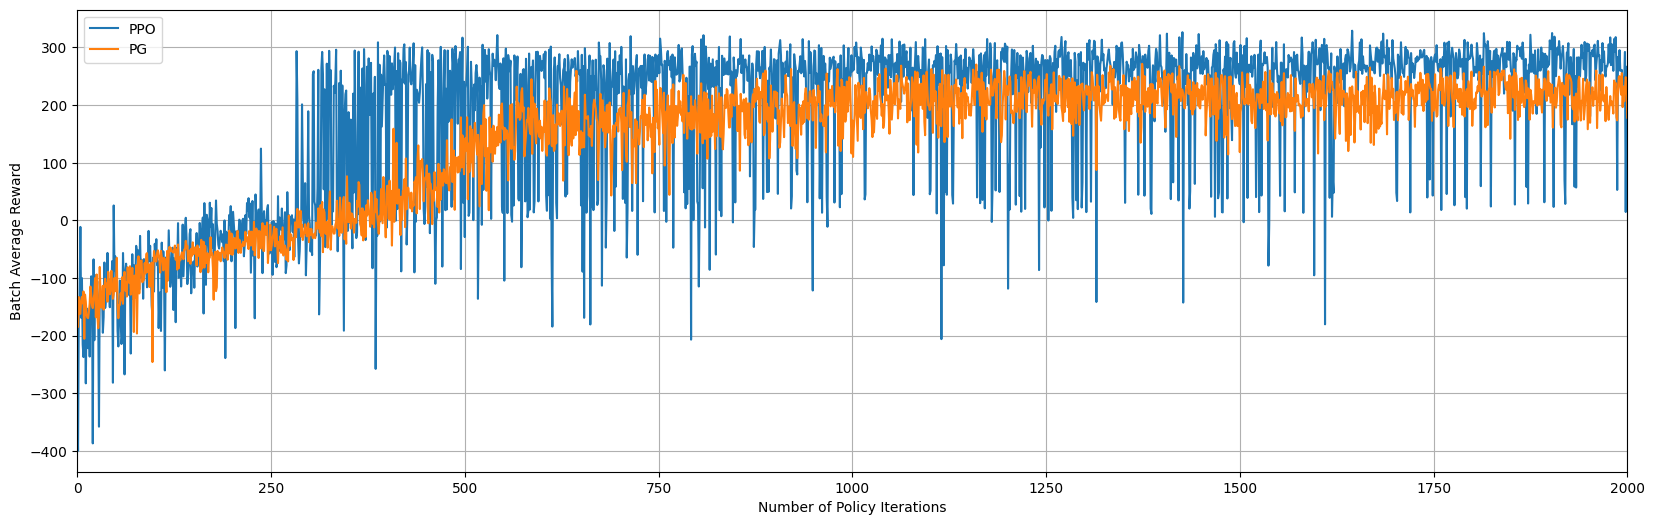

In [108]:
plt.figure(figsize=(20, 6))
plt.plot(ppo_reward_list,label='PPO')
plt.plot(pg_reward_list,label='PG')
plt.grid(True)
plt.xlim([0,2000])
plt.legend()
plt.xlabel('Number of Policy Iterations')
plt.ylabel('Batch Average Reward')

# 修改Batch size

In [81]:
# load_filename = 'checkpoint_1250.pth'
load_filename = None
batch = 0
save_directory = "./ppo_weight_64"

ppo_agent = PPOAgent(observation_space ,action_space, hidden_size, lr, eps, gamma, K_epochs, eps_clip, update_timestep)
BATCH_SIZE = 64

ppo_reward_list_64 = []

if load_filename is not None:
    batch = ppo_agent.load_checkpoint(save_directory, load_filename)

while batch <= MAX_NUM_BATCH:
    rewards = []
    total_rewards = []

    for _ in range(BATCH_SIZE):
        state = env.reset()[0]
        total_reward = 0
        done = False
        # while not done:
        for _ in range(10000):
            action = ppo_agent.act(state)
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            total_reward += reward 
            rewards.append(reward)
            ppo_agent.step(reward, done)   
            if done: 
                # total_rewards.append(total_reward)
                break
    batch += 1
    total_rewards.append(total_reward)
    
    if batch % 50 == 0 and save_directory is not None:
        ppo_agent.save_checkpoint(save_directory, batch)

    print('Batch: {}, average reward: {}'.format(batch, np.array(total_rewards).mean()))
    ppo_reward_list_64.append(np.array(total_rewards).mean())

env.close()
    

Batch: 1, average reward: -99.70008547852395
Batch: 2, average reward: -161.5626162500581
Batch: 3, average reward: -101.34163450221814
Batch: 4, average reward: -163.87011817496287
Batch: 5, average reward: -301.7932422260403
Batch: 6, average reward: -58.57318867948106
Batch: 7, average reward: -99.76930750720462
Batch: 8, average reward: -148.17927429224986
Batch: 9, average reward: -60.85125287449493
Batch: 10, average reward: -103.55992735756934
Batch: 11, average reward: -27.70535205020434
Batch: 12, average reward: -41.32250838001696
Batch: 13, average reward: -82.33922134978899
Batch: 14, average reward: -246.69045237585365
Batch: 15, average reward: -59.107833361195546
Batch: 16, average reward: -79.11936233603699
Batch: 17, average reward: -60.00787825784262
Batch: 18, average reward: -14.42293868853784
Batch: 19, average reward: -18.504813202560342
Batch: 20, average reward: -97.83686734853543
Batch: 21, average reward: -234.7434186196113
Batch: 22, average reward: -71.57330

In [82]:
# load_filename = 'checkpoint_1250.pth'
load_filename = None
batch = 0
save_directory = "./ppo_weight_32"

ppo_agent = PPOAgent(observation_space ,action_space, hidden_size, lr, eps, gamma, K_epochs, eps_clip, update_timestep)
BATCH_SIZE = 32

ppo_reward_list_32 = []

if load_filename is not None:
    batch = ppo_agent.load_checkpoint(save_directory, load_filename)

while batch <= MAX_NUM_BATCH:
    rewards = []
    total_rewards = []

    for _ in range(BATCH_SIZE):
        state = env.reset()[0]
        total_reward = 0
        done = False
        # while not done:
        for _ in range(10000):
            action = ppo_agent.act(state)
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            total_reward += reward 
            rewards.append(reward)
            ppo_agent.step(reward, done)   
            if done: 
                # total_rewards.append(total_reward)
                break
    batch += 1
    total_rewards.append(total_reward)
    
    if batch % 50 == 0 and save_directory is not None:
        ppo_agent.save_checkpoint(save_directory, batch)

    print('Batch: {}, average reward: {}'.format(batch, np.array(total_rewards).mean()))
    ppo_reward_list_32.append(np.array(total_rewards).mean())

env.close()
    

Batch: 1, average reward: -116.70033288903379
Batch: 2, average reward: -258.02884021163027
Batch: 3, average reward: -200.78725570529232
Batch: 4, average reward: -98.80529883359094
Batch: 5, average reward: -264.21107047196983
Batch: 6, average reward: -113.84017520663492
Batch: 7, average reward: -335.50741855947314
Batch: 8, average reward: -163.03539103904842
Batch: 9, average reward: -128.50565443895357
Batch: 10, average reward: -330.3151178123652
Batch: 11, average reward: -60.4010696155961
Batch: 12, average reward: -156.3776873087707
Batch: 13, average reward: -77.66568743062405
Batch: 14, average reward: -74.82455102457111
Batch: 15, average reward: -101.0481307723989
Batch: 16, average reward: -109.88024440084008
Batch: 17, average reward: -215.40359689654701
Batch: 18, average reward: -127.47432266988383
Batch: 19, average reward: 16.21986373691044
Batch: 20, average reward: -106.80187116819938
Batch: 21, average reward: -118.90440256906504
Batch: 22, average reward: -135.

Text(0, 0.5, 'Batch Average Reward')

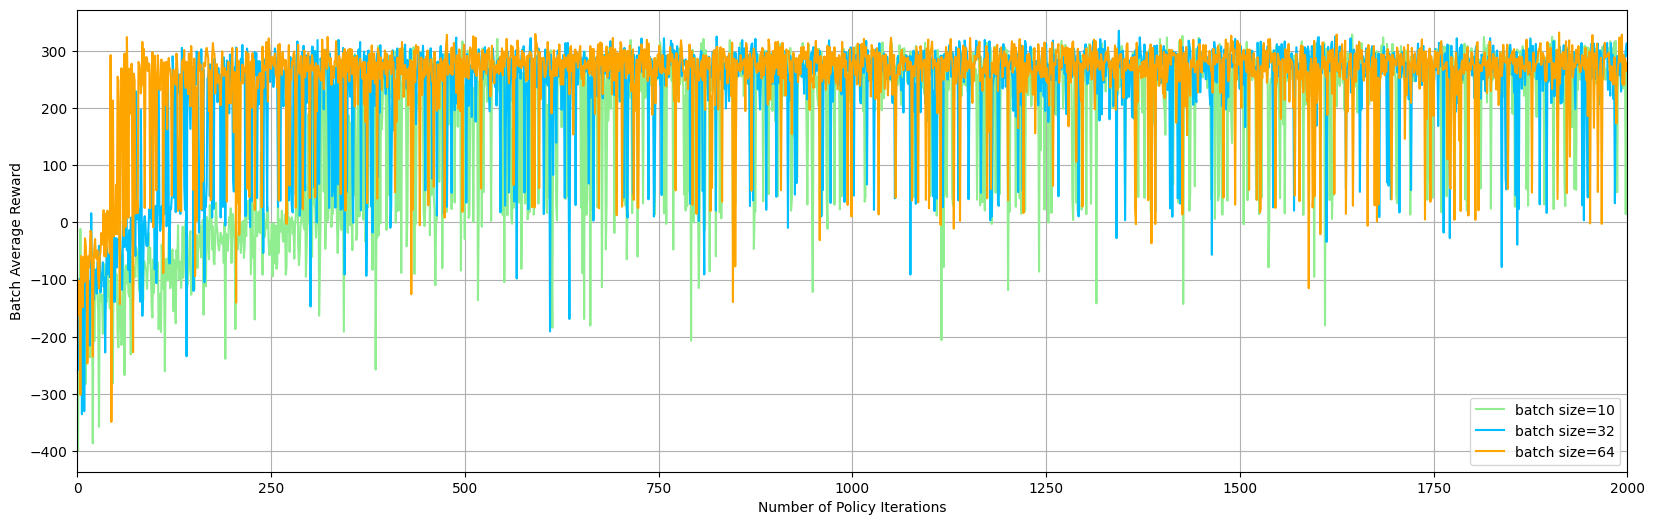

In [109]:
plt.figure(figsize=(20, 6))

plt.plot(ppo_reward_list, label='batch size=10',color='lightgreen')
plt.plot(ppo_reward_list_32, label='batch size=32',color='deepskyblue')
plt.plot(ppo_reward_list_64, label='batch size=64',color='orange')

plt.grid(True)
plt.xlim([0, 2000])
plt.legend()
plt.xlabel('Number of Policy Iterations')
plt.ylabel('Batch Average Reward')
